In [1]:
# Classify ImageNet classes with ResNet50
import matplotlib.pyplot as plt
import numpy as np
import os
import random

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.models import Model
from keras.layers import Input, Dense
from keras.preprocessing import image


%matplotlib inline

Using TensorFlow backend.


In [ ]:
from keras.models import Sequential
from keras.utils import to_categorical
from keras import metrics

data = np.random.random((10,10))
labels = np.random.random((10, 2))
print(labels)

model = Sequential()
model.add(Dense(256, activation='relu', input_dim=10))
model.add(Dense(256, activation='relu', input_dim=10))
model.add(Dense(1024, activation='relu', input_dim=10))
model.add(Dense(1024, activation='relu', input_dim=10))
model.add(Dense(2, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=[metrics.mse, metrics.mean_absolute_percentage_error])

model.fit(data, labels)

In [2]:
inputs = Input(shape=(784,))

output_1 = Dense(64, activation='relu')(inputs)
output_2 = Dense(64, activation='relu')(output_1)
predictions = Dense(10, activation='softmax')(output_2)

model = Model(inputs=inputs, outputs=predictions, name="ddd")

config = model.get_config()

model2 = Model.from_config(config)
# print(model2.summary())

weight = model.get_weights()
# print(model.layers[1].get_weights()[0].shape)

json_string = model.to_json()

# print(json_string)

In [5]:
#  Data Parallelism
from keras.utils import multi_gpu_model

# Replicates `model` on 8 GPUs.
# This assumes that your machine has 8 available GPUs.
parallel_model = multi_gpu_model(model, gpus=2)
parallel_model.compile(loss='categorical_crossentropy',
                       optimizer='rmsprop')

# This `fit` call will be distributed on 8 GPUs.
# Since the batch size is 256, each GPU will process 32 samples.
# parallel_model.fit(x, y, epochs=20, batch_size=256)

* Epoch

In [10]:
DATA_DIR = os.path.abspath('../../data/Oxford_Pet_Dataset/images')

def LoadImage():
    img_path = os.path.join(DATA_DIR, random.choice(os.listdir(DATA_DIR)))
    img = image.load_img(img_path, target_size=(224, 224))
    return img

def Preprocessing(img):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [11]:
# Load VGG16 Without FC Layer

model = VGG16(weights='imagenet', include_top=False)
# print(model.summary())

# Feature Extraction result(VGG16 기준 block5_pool output(7 x 7 x 512))
img = LoadImage()
x = Preprocessing(img)
feature = model.predict(x)
print('Block5_pool feature shape :: ', feature.shape)

# 특정 Layer Feature Extraction Result(VGG16 기준 block4_pool output(7 x 7 x 512))
model2 = Model(inputs=model.input, outputs=model.get_layer('block4_pool').output)
block_4_pool_feature = model2.predict(x)
print('Block4_pool feature shape :: ', block_4_pool_feature.shape)

Block5_pool feature shape ::  (1, 7, 7, 512)
Block4_pool feature shape ::  (1, 14, 14, 512)


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

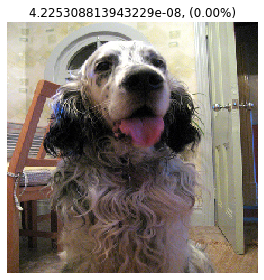

In [13]:
# Load VGG16 With FC Layerhttps://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
model = VGG16(weights='imagenet', include_top=True)
print(model.summary())
# Classification for OxFord Pet Dataset using ImageNet + VGG16 Pretraining model
img = LoadImage()
x = Preprocessing(img)
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

plt.axis('off')
plt.title('{}, ({:0.2%})'.format(preds[0][1], preds[0][2]))
plt.imshow(img)
plt.tight_layout()


In [14]:
model = VGG16(weights='imagenet', include_top=True)

for layers in (model.layers)[:15]:
    layers.trainable = False

# Transfer Learning(ConvNet as Fixed Featrue Extractor)
x = model.layers[-2].output
predictions = Dense(2, activation='softmax')(x)
model_final = Model(inputs = model.input, outputs = predictions)

print(model_final.summary())

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
# GPU Memory Release
'''
from numba import cuda
GPU_NUM = 0
cuda.select_device(GPU_NUM)
cuda.close()
'''